In [ ]:
!pip3 install pyro-ppl 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 5.1 MB/s 


In [ ]:
!pip install extinction

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 4.4 MB/s 


In [ ]:
!pip install corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors

import corner
import time as measure_time
import os
import math

import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO,Predictive
from pyro.optim import Adam
from pyro.ops.stats import fit_generalized_pareto

from scipy.interpolate import interp1d
import h5py
import extinction

from astropy.cosmology import FlatLambdaCDM

from spline_hsiao_fns import *

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


##Get constants from files

In [ ]:
W0 = np.loadtxt("W0_T21.txt")
W1 = np.loadtxt("W1_T21.txt")
W0_tensor = torch.as_tensor(W0).to(device)
W1_tensor = torch.as_tensor(W1).to(device)
time_knots = np.loadtxt("tau_knots_T21.txt")
wavelength_knots = np.loadtxt("l_knots_T21.txt")
L_sigma_epsilon = np.loadtxt("L_Sigma_epsilon_T21.txt")
L_sigma_epsilon_tensor = torch.as_tensor(L_sigma_epsilon, dtype = torch.float).to(device)
M0, sigma0, rv, tauA = np.loadtxt("M0_sigma0_RV_tauA_T21.txt")
cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)

In [ ]:
g_wavelengths, _, g_norm_throughput = np.loadtxt("g_PS1.txt", skiprows = 2, unpack = True)
r_wavelengths, _, r_norm_throughput = np.loadtxt("r_PS1.txt", skiprows = 2, unpack = True)
i_wavelengths, _, i_norm_throughput = np.loadtxt("i_PS1.txt", skiprows = 2, unpack = True)
z_wavelengths, _, z_norm_throughput = np.loadtxt("z_PS1.txt", skiprows = 2, unpack = True)

Read in metadata for Foundation dataset

In [ ]:
meta = pd.read_csv("meta.txt", sep='\s+', index_col = False, names = ['SNID','PEAKMJD','MWEBV','REDSHIFT_HELIO','REDSHIFT_CMB','REDSHIFT_CMB_ERR'], skiprows = 2)

In [ ]:
tmax_dict = {}
mwebv_dict = {}
z_helio_dict = {}
z_cmb_dict = {}
for index, row in meta.iterrows():
  name = row['SNID']
  tmax = row['PEAKMJD']
  mwebv = row['MWEBV']
  z_helio = row['REDSHIFT_HELIO']
  z_cmb = row['REDSHIFT_CMB']
  tmax_dict[name] = tmax
  mwebv_dict[name] = mwebv
  z_helio_dict[name] = z_helio
  z_cmb_dict[name] = z_cmb

In [ ]:
def get_fluxes_from_file(filename, tmax, z_helio):
  df = pd.read_csv(filename, sep=" ", header = 0, index_col = False, names = ['MJD', "FLT", 'FLUXCAL', 'FLUXCALERR', 'MAG', 'MAGERR'])
  df = df.dropna()

  # Remove time points outside of [-10., 40.]
  df['adj_time'] = (df.MJD - tmax) / (1 + z_helio)
  mask = (df['adj_time'] < 40.) & (df['adj_time'] > -10.0)
  df = df[mask]

  # Separate based on bands
  g_time = df.adj_time[df.FLT=='g'].values
  r_time = df.adj_time[df.FLT=='r'].values
  i_time = df.adj_time[df.FLT=='i'].values
  z_time = df.adj_time[df.FLT=='z'].values

  g_flux = df.FLUXCAL[df.FLT=='g'].values
  r_flux = df.FLUXCAL[df.FLT=='r'].values
  i_flux = df.FLUXCAL[df.FLT=='i'].values
  z_flux = df.FLUXCAL[df.FLT=='z'].values

  g_fluxerr = df.FLUXCALERR[df.FLT=='g'].values
  r_fluxerr = df.FLUXCALERR[df.FLT=='r'].values
  i_fluxerr = df.FLUXCALERR[df.FLT=='i'].values
  z_fluxerr = df.FLUXCALERR[df.FLT=='z'].values

  times_dict = {'g':g_time, 'r':r_time, 'i':i_time, 'z':z_time}

  observed_fluxes = [torch.as_tensor(g_flux).to(device), torch.as_tensor(r_flux).to(device), torch.as_tensor(i_flux).to(device), torch.as_tensor(z_flux).to(device)]

  flux_errors = [torch.as_tensor(g_fluxerr).to(device), torch.as_tensor(r_fluxerr).to(device), torch.as_tensor(i_fluxerr).to(device), torch.as_tensor(z_fluxerr).to(device)]

  return observed_fluxes, flux_errors, times_dict

In [ ]:
ZPT = torch.as_tensor(27.5).to(device)
M0 = torch.as_tensor(-19.5).to(device)
gamma = torch.as_tensor(np.log(10) / 2.5).to(device)
gamma_numpy = np.log(10) / 2.5

hsiao_phase, hsiao_wave, hsiao_flux = read_model_grid()

bands = ['g', 'r', 'i', 'z']
wavelengths_dict = {'g':g_wavelengths, 'r':r_wavelengths, 'i':i_wavelengths, 'z':z_wavelengths}
norm_throughput_dict = {'g':g_norm_throughput, 'r':r_norm_throughput, 'i':i_norm_throughput, 'z':z_norm_throughput}
eps_cov = torch.as_tensor(np.matmul(L_sigma_epsilon, L_sigma_epsilon.T), dtype = torch.float)

Things we can pre-calculate / helper functions
---



In [ ]:
def get_lambda_int_for_band(band_wavelengths, z):
  source_wavelengths = band_wavelengths / (1 + z)
  return np.linspace(np.min(source_wavelengths), np.max(source_wavelengths), 75)

In [ ]:
def calculate_band_dependent_stuff(times_dict, z_helio, Av_obs):
  band_Jl = {}
  band_h = {}
  band_Jt = {}
  band_xis_matrix = {}
  band_S0 = {}  

  for band in bands:
    # Calculate Jt
    times_to_interpolate = times_dict[band]
    Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))
    band_Jt[band] = torch.as_tensor(Jt.T).to(device)

    # Calculate wavelengths to interpolate
    band_wavelengths = wavelengths_dict[band]
    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z = z_helio)

    # Calculate Jl (J matrix for wavelengths)
    Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    band_Jl[band] = torch.as_tensor(Jl).to(device)

    # Calculate xis matrix
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T
    band_xis_matrix[band] = torch.as_tensor(xis_matrix).to(device)

    # Interpolate throughput wavelengths
    band_norm_throughput = norm_throughput_dict[band]
    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z_helio)) + [band_wavelengths[-1]])

    # Calculate S0 matrix
    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time_point in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time_point, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)
    band_S0[band] = torch.as_tensor(S0).to(device)

    # Calculate h
    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z_helio), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + z_helio) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma_numpy * xis_obs)
    band_h[band] = torch.as_tensor(h).to(device)

  return band_Jt, band_Jl, band_xis_matrix, band_S0, band_h

## Define model

In [ ]:
nu_args = torch.zeros(len(L_sigma_epsilon)).to(device), torch.eye(len(L_sigma_epsilon)).to(device)
theta_args = torch.as_tensor(0.).to(device), torch.as_tensor(1.0).to(device)
mu_arg = torch.as_tensor(10.0).to(device)
av_arg = torch.as_tensor(1 / 0.252).to(device)

zeros = torch.zeros(6).to(device)

In [ ]:
def model_vi_with_params_faster(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors):
  nu = pyro.sample("nu", dist.MultivariateNormal(*nu_args))
  epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), torch.squeeze(nu).float())

  theta = pyro.sample("theta", dist.Normal(*theta_args))

  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, mu_arg))

  dMs = torch.tensor(0.).to(device)
  Av = pyro.sample("Av", dist.Exponential(av_arg))

  # epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  # epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)
  epsilon = torch.vstack((zeros, torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1), zeros))

  W = W0_tensor + theta*W1_tensor + epsilon

  generated_fluxes = np.empty(4, object)

  for band_index, band in enumerate(bands):
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    # for var in [Jl, S0, xis_matrix, h, Jt]:
    #   print(var.get_device())

    JlWJt = torch.matmul(band_Jl[band], torch.matmul(W, band_Jt[band]))

    Stilde = band_S0[band] * torch.exp(-gamma * (JlWJt + Av * band_xis_matrix[band]))

    f = 10**(0.4 * (ZPT - mu_s - M0 - dMs)) * torch.matmul(band_h[band], Stilde)
    generated_fluxes[band_index] = f
    # generated_fluxes.append(f)
  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)
  

  # for var in [nu, epsilon_interior, theta, mu_s, dMs, Av, epsilon, W]:
  #   print(var.get_device())

  # if obs is not None:
    # for i in range(len(bands)):
  for i in pyro.plate("bands", band_index + 1):
    # print(i, band_index)
    with pyro.plate("observations" + str(bands[i])):
      # print(len(generated_fluxes[i]))
      # for j in range(len(generated_fluxes[i])):
        # print(generated_fluxes[i].get_device())
        # print(flux_errors[i].get_device())
        # print(obs[i].get_device())
        pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[i]), obs = obs[i])
        # print(obs[0][i][j])
      # print(generated_fluxes[i])


In [ ]:
def model_vi_with_params_faster_predictive_posterior(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors):
  nu = pyro.sample("nu", dist.MultivariateNormal(*nu_args))
  epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), nu.float())

  theta = pyro.sample("theta", dist.Normal(*theta_args))

  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, mu_arg))

  dMs = torch.tensor(0.).to(device)
  Av = pyro.sample("Av", dist.Exponential(av_arg))

  # epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  # epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)
  epsilon = torch.vstack((zeros, torch.transpose(torch.reshape(epsilon_interior, (6,4)), 0, 1), zeros))

  W = W0_tensor + theta*W1_tensor + epsilon

  generated_fluxes = np.empty(4, object)

  for band_index, band in enumerate(bands):
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    JlWJt = torch.matmul(band_Jl[band], torch.matmul(W, band_Jt[band]))

    Stilde = band_S0[band] * torch.exp(-gamma * (JlWJt + Av * band_xis_matrix[band]))

    f = 10**(0.4 * (ZPT - mu_s - M0 - dMs)) * torch.matmul(band_h[band], Stilde)
    generated_fluxes[band_index] = f

  if obs is not None:
    for i in pyro.plate("bands", band_index + 1):
      with pyro.plate("observations" + str(bands[i])):
          pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[i]), obs = obs[i])

In [ ]:
def model_vi_with_params_faster_uniform_av(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors):
  nu = pyro.sample("nu", dist.MultivariateNormal(*nu_args))
  epsilon_interior = torch.matmul(L_sigma_epsilon_tensor.float(), nu.float())

  theta = pyro.sample("theta", dist.Normal(*theta_args))

  mu_s = pyro.sample("mu_s", dist.Normal(mu_mean, mu_arg))

  dMs = torch.tensor(0.).to(device)
  # Av = pyro.sample("Av", dist.Uniform(-1., 2.))
  Av = pyro.sample("Av", dist.AsymmetricLaplace(0, 0.252 / 10, 0.1))

  # epsilon = torch.zeros(W0.shape)   ## populate epsilon matrix
  # epsilon[1:-1] = torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1)
  epsilon = torch.vstack((zeros, torch.transpose(torch.reshape(epsilon_interior, (6,9)), 0, 1), zeros))

  W = W0_tensor + theta*W1_tensor + epsilon

  generated_fluxes = np.empty(4, object)

  for band_index, band in enumerate(bands):
    Jl = band_Jl[band]
    S0 = band_S0[band]
    xis_matrix = band_xis_matrix[band]
    h = band_h[band]
    Jt = band_Jt[band]

    # for var in [Jl, S0, xis_matrix, h, Jt]:
    #   print(var.get_device())

    JlWJt = torch.matmul(band_Jl[band], torch.matmul(W, band_Jt[band]))

    Stilde = band_S0[band] * torch.exp(-gamma * (JlWJt + Av * band_xis_matrix[band]))

    f = 10**(0.4 * (ZPT - mu_s - M0 - dMs)) * torch.matmul(band_h[band], Stilde)
    generated_fluxes[band_index] = f
    # generated_fluxes.append(f)
  # generated_fluxes = torch.stack(generated_fluxes)
  # print(generated_fluxes)
  

  # for var in [nu, epsilon_interior, theta, mu_s, dMs, Av, epsilon, W]:
  #   print(var.get_device())

  # if obs is not None:
    # for i in range(len(bands)):
  for i in pyro.plate("bands", band_index + 1):
    # print(i, band_index)
    with pyro.plate("observations" + str(bands[i])):
      # print(len(generated_fluxes[i]))
      # for j in range(len(generated_fluxes[i])):
        # print(generated_fluxes[i].get_device())
        # print(flux_errors[i].get_device())
        # print(obs[i].get_device())
        pyro.sample("flux" + str(bands[i]), dist.Normal(generated_fluxes[i], flux_errors[i]), obs = obs[i])

In [ ]:
def train_with_params_faster(model, guide, obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, lr=0.01, n_steps=5000, verbose= False):
  pyro.get_param_store().clear()
  # adam = pyro.optim.Adam({"lr": 0.05}, {"clip_norm": 10.0})
  adam = pyro.optim.ClippedAdam({"lr": lr, "betas": (0.95, 0.999)})
  svi = SVI(model, guide, adam, loss=Trace_ELBO())
  # print('hi')
  for step in range(n_steps):
      loss = svi.step(obs, mu_mean, band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors)
      if verbose and step % 500 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))
          ## if it hasn't decreased in 3 steps, end fitting
          # if step > 2000:
          #  if losses_every_500[-1] >= losses_every_500[-2] and losses_every_500[-2] >= losses_every_500[-3]:
          #   break


In [ ]:
def get_psis_metric(model, guide, num_particles = 1000):
  pyro.get_param_store().clear()
  ## Code modified from https://pyro4ci.readthedocs.io/en/latest/_modules/pyro/infer/importance.html#psis_diagnostic
  log_weights = torch.as_tensor([pyro.infer.importance.vectorized_importance_weights(model, guide, observed_fluxes, mu_mean, 
              band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, max_plate_nesting = 2)[0] for _ in range(num_particles)])
  # log_weights = torch.cat(log_weights)
  log_weights -= log_weights.max()
  log_weights = torch.sort(log_weights, descending=False)[0]
  cutoff_index = - int(math.ceil(min(0.2 * num_particles, 3.0 * math.sqrt(num_particles)))) - 1
  lw_cutoff = max(math.log(1.0e-15), log_weights[cutoff_index])
  lw_tail = log_weights[log_weights > lw_cutoff]

  if len(lw_tail) < 10:
      # warnings.warn("Not enough tail samples to compute PSIS diagnostic; increase num_particles.")
      k = float('inf')
  else:
      k, _ = fit_generalized_pareto(lw_tail.exp() - math.exp(lw_cutoff))
  return k

In [ ]:
list(meta.SNID.values).index('ASASSN-17at')

55

In [ ]:
 # laplace_samples = {}
# laplace_vi_loc = {}
# laplace_vi_scale_tril = {}

# laplace_approxes = {}

# laplace_no_vi_loc = {}
# laplace_no_vi_scale_tril = {}

for sn in meta.SNID.values[55:]:
  print(sn)

  tmax = tmax_dict[sn]
  z_helio = z_helio_dict[sn]
  EBV_MW = mwebv_dict[sn]
  z_cmb = z_cmb_dict[sn]

  Av_obs = EBV_MW * 3.1
  observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

  # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
  band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs)
  mu_mean = torch.as_tensor(cosmo.distmod(z_cmb).value).to(device)


  try:

    start_time = measure_time.time()
    # Fit Laplace Approximation

    # autoguide_laplace1 = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
    # train_with_params_faster(model_vi_with_params_faster, autoguide_laplace1, observed_fluxes, mu_mean, 
    #                 band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
      
    # first_laplace_guide = autoguide_laplace1.laplace_approximation(observed_fluxes, mu_mean, 
    #                 band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)

    # # print(first_laplace_guide.get_posterior().loc.numpy()[-2])

    # laplace_no_vi_loc[sn] = first_laplace_guide.get_posterior().loc.numpy()
    # laplace_no_vi_scale_tril[sn] = first_laplace_guide.get_posterior().scale_tril.numpy()

    autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
    train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, observed_fluxes, mu_mean, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
    

    # Fit VI based on Laplace Approximation
    new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, mu_mean, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
    

    train_with_params_faster(model_vi_with_params_faster, new_laplace_approx_guide, observed_fluxes, mu_mean, 
                  band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=6000, verbose = True)
    
    laplace_vi_loc[sn] = new_laplace_approx_guide.get_posterior().loc.numpy()
    laplace_vi_scale_tril[sn] = new_laplace_approx_guide.get_posterior().scale_tril.numpy()

    end_time = measure_time.time()
    print("Time:", end_time - start_time, "seconds")

    np.save("foundation_laplace_vi_loc_071422_T21.npy", laplace_vi_loc)
    np.save("foundation_laplace_vi_scale_tril_071422_T21.npy", laplace_vi_scale_tril)



  except:
    try:
      print("trying again")

      start_time = measure_time.time()

      autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
      train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, observed_fluxes, mu_mean, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
    

      # Fit VI based on Laplace Approximation
      new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, mu_mean, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)


      train_with_params_faster(model_vi_with_params_faster, new_laplace_approx_guide, observed_fluxes, mu_mean, 
                    band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=5000, verbose = True)
    
      end_time = measure_time.time()
      print("Time:", end_time - start_time, "seconds")

      laplace_vi_loc[sn] = new_laplace_approx_guide.get_posterior().loc.numpy()
      laplace_vi_scale_tril[sn] = new_laplace_approx_guide.get_posterior().scale_tril.numpy()

      np.save("foundation_laplace_vi_loc_071422_T21.npy", laplace_vi_loc)
      np.save("foundation_laplace_vi_scale_tril_071422_T21.npy", laplace_vi_scale_tril)

    except:
      print("Did not work for", sn)

ASASSN-17at
Time: 57.53787422180176 seconds
ASASSN-17bs
Time: 53.94096755981445 seconds
ASASSN-17co
Time: 52.199925661087036 seconds
ASASSN-17eb
Time: 55.603365421295166 seconds
AT2016aj
Time: 52.152721643447876 seconds
AT2016bln
Time: 52.60493326187134 seconds
AT2016cor
Time: 53.342026472091675 seconds
AT2016cvv
Time: 53.3523588180542 seconds
AT2016cvw
Time: 51.949355602264404 seconds
AT2016cyt
Time: 52.77719974517822 seconds
AT2016eoa
Time: 51.23973822593689 seconds
AT2016ews
Time: 51.11773109436035 seconds
AT2016fbk
Time: 51.232120990753174 seconds
AT2016gmg
Time: 50.86080622673035 seconds
AT2016gsu
Time: 51.50015211105347 seconds
AT2016hns
Time: 51.6098952293396 seconds
AT2016htm
Time: 51.99819302558899 seconds
AT2016htn
Time: 52.51470160484314 seconds
AT2017cfb
Time: 50.867918491363525 seconds
AT2017cfc
Time: 51.589054584503174 seconds
AT2017lm
Time: 50.76464247703552 seconds
AT2017ns
Time: 50.88691997528076 seconds
AT2017oz
Time: 50.54515886306763 seconds
AT2017po
Time: 50.689416

## Make Hubble Diagram

In [ ]:
# vi_loc_dict = np.load("foundation_vi_loc.npy", allow_pickle = True).item()
# laplace_vi_loc_dict = np.load("laplace_vi_loc_redo.npy", allow_pickle = True).item()
# laplace_vi_scale_tril_dict = np.load("laplace_vi_scale_tril_redo.npy", allow_pickle = True).item()
laplace_vi_loc_dict = np.load("foundation_laplace_vi_loc_080222_T21.npy", allow_pickle = True).item()
laplace_vi_scale_tril_dict = np.load("foundation_laplace_vi_scale_tril_080222_T21.npy", allow_pickle = True).item()
# vi_scale_tril_dict = np.load("foundation_vi_scale_tril.npy", allow_pickle = True).item()

In [ ]:
len(laplace_vi_loc_dict)

157

In [ ]:
list(meta.SNID.values).index('ASASSN-16aj')

34

In [ ]:
# for sn in meta.SNID.values[34:35]:
#   print(sn)

#   tmax = tmax_dict[sn]
#   z_helio = z_helio_dict[sn]
#   EBV_MW = mwebv_dict[sn]
#   z_cmb = z_cmb_dict[sn]
#   mu_mean = torch.as_tensor(cosmo.distmod(z_cmb).value).to(device)


#   Av_obs = EBV_MW * 3.1
#   observed_fluxes, flux_errors, times_dict = get_fluxes_from_file(sn + ".dat", tmax, z_helio)

#   # Calculate band-dependent quantities (Jl, Jt, xis, S0, etc.)
#   band_Jt, band_Jl, band_xis_matrix, band_S0, band_h = calculate_band_dependent_stuff(times_dict, z_helio, Av_obs)

#   autoguide_laplace = pyro.infer.autoguide.AutoLaplaceApproximation(model_vi_with_params_faster)
#   train_with_params_faster(model_vi_with_params_faster, autoguide_laplace, observed_fluxes, mu_mean, 
#                 band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=3000, verbose = True)
  

#   # Fit VI based on Laplace Approximation
#   new_laplace_approx_guide = autoguide_laplace.laplace_approximation(observed_fluxes, mu_mean, 
#                 band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors,)
  

#   train_with_params_faster(model_vi_with_params_faster, new_laplace_approx_guide, observed_fluxes, mu_mean, 
#                 band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors, n_steps=6000, verbose = True)
  
#   # laplace_vi_loc[sn] = new_laplace_approx_guide.get_posterior().loc.numpy()
#   # laplace_vi_scale_tril[sn] = new_laplace_approx_guide.get_posterior().scale_tril.numpy()


In [ ]:
# laplace_vi_loc_dict['ASASSN-16aj'] = new_laplace_approx_guide.get_posterior().loc.numpy()
# laplace_vi_scale_tril_dict['ASASSN-16aj'] = new_laplace_approx_guide.get_posterior().scale_tril.numpy()

In [ ]:
# np.save("foundation_laplace_vi_loc_080222_T21.npy", laplace_vi_loc_dict)
# np.save("foundation_laplace_vi_scale_tril_080222_T21.npy", laplace_vi_scale_tril_dict)

In [ ]:
vi_mus = []
vi_vars = []
laplace_vi_mus = []
laplace_vi_vars = []

vi_z_cmbs = []

laplace_vi_z_cmbs = []


for sn in list(laplace_vi_loc_dict.keys()):
  # if sn != "ASASSN-16aj":
    try:
      vi_mus.append(vi_loc_dict[sn][-2])
      vi_scale_tril = vi_scale_tril_dict[sn]
      # Calculate covariance matrix from scale_tril (sigma = LL^T)
      vi_vars.append(np.matmul(vi_scale_tril, vi_scale_tril.T)[-2][-2])
      vi_z_cmbs.append(z_cmb_dict[sn])
    except:
      pass

    try:
      laplace_vi_mus.append(laplace_vi_loc_dict[sn][-2])
      laplace_vi_scale_tril = laplace_vi_scale_tril_dict[sn]
      laplace_vi_vars.append(np.matmul(laplace_vi_scale_tril, laplace_vi_scale_tril.T)[-2][-2])
      laplace_vi_z_cmbs.append(z_cmb_dict[sn])
    except:
      pass

In [ ]:
max(laplace_vi_vars)

0.12743195168110133

In [ ]:
laplace_vi_vars.index(max(laplace_vi_vars))

8

In [ ]:
len(laplace_vi_z_cmbs)

157

VI from Laplace Hubble Diagram

In [ ]:
linspace_z = np.linspace(0.01, 0.085)

cosmo = FlatLambdaCDM(H0 = 73.24, Om0 = 0.28)
cosmo_distmod_values = np.array([cosmo.distmod(z).value for z in linspace_z])

In [ ]:
predictions = laplace_vi_mus
targets = np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs])

rmse = np.sqrt(np.mean((predictions-targets)**2))
print(rmse)

0.12321166413020739


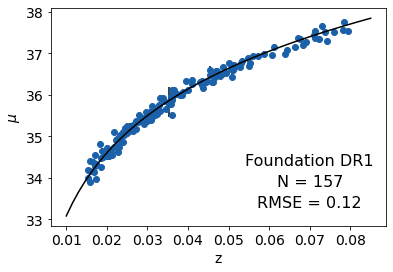

In [ ]:
f = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus, 'o', color = (0.104,0.382,0.664))
plt.plot(linspace_z, cosmo_distmod_values, color = 'k')
plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus, np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')
plt.xlabel("z", fontsize =14)
plt.ylabel("$\\mu$", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(0.07, 34.3, "Foundation DR1", fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.8, "N = " + str(len(laplace_vi_z_cmbs)), fontsize = 16, horizontalalignment = 'center')
plt.text(0.07, 33.3, "RMSE = " + str(round(rmse,2)), fontsize = 16, horizontalalignment = 'center')
f.savefig("HubbleDiagram_T21_080222.pdf", bbox_inches = 'tight')
# plt.title("Foundation dataset distances- VI initialized with Laplace", fontsize = 12)

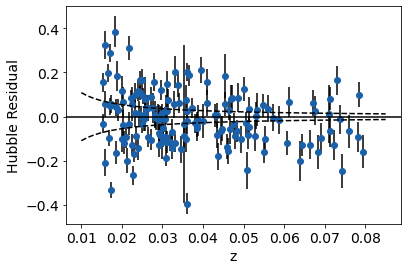

In [ ]:
g = plt.figure()
plt.plot(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), 'o',color = (0.104,0.382,0.664))

plt.errorbar(laplace_vi_z_cmbs, laplace_vi_mus - np.array([cosmo.distmod(z).value for z in laplace_vi_z_cmbs]), np.sqrt(laplace_vi_vars), linestyle = 'None', color = 'k')


sigma_pec = 150
c = 300000

sigma_envelope = np.array([(5 / (z * np.log(10))) * (sigma_pec / c) for z in linspace_z])

plt.plot(linspace_z, sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')
plt.plot(linspace_z, -sigma_envelope, marker = 'None', linestyle = 'dashed', color = 'k')

plt.axhline(0., color = 'k')

plt.xlabel("z", fontsize = 14)
plt.ylabel("Hubble Residual", fontsize = 14)
# plt.ylim(-1, 1)
# plt.title("Foundation dataset residuals- VI initialized with Laplace", fontsize = 12)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()
g.savefig("HubbleResiduals.pdf", bbox_inches = 'tight')

##Generate figures for Stephen's talk

In [ ]:
sn = 'ASASSN-16cs'

In [ ]:
def get_vi_samples(sn, num_samples = 1000):
  # print(laplace_vi_loc_dict[sn])
  # print(laplace_vi_scale_tril_dict[sn])
  dist = torch.distributions.MultivariateNormal(torch.as_tensor(laplace_vi_loc_dict[sn]), scale_tril = torch.as_tensor(laplace_vi_scale_tril_dict[sn]))
  sn_vi_samples = dist.sample((num_samples,)).numpy()
  # print(np.shape(sn_vi_samples[:,-1]))
  theta_samples = sn_vi_samples[:,-3]
  av_samples = np.exp(sn_vi_samples[:,-1])
  mu_samples = sn_vi_samples[:,-2]
  return np.vstack((mu_samples, theta_samples, av_samples)).T

In [ ]:
mcmc_estimate = np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()
laplace_vi_samples = get_vi_samples(sn)

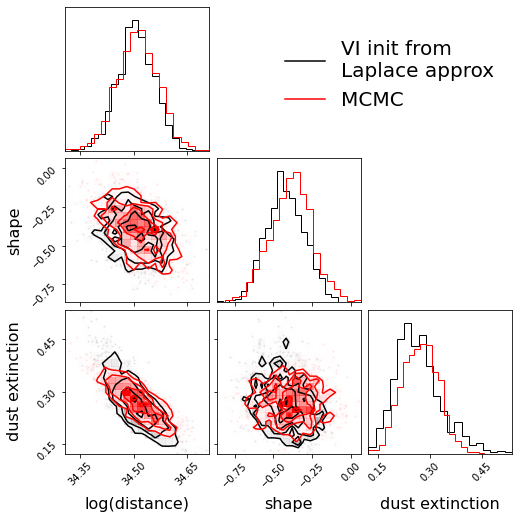

In [ ]:
figure = corner.corner(laplace_vi_samples,
                       labels = ["log(distance)", "shape", "dust extinction"], color = 'k')
# # corner.corner(np.vstack((laplace_samples['mu_s'][:,0,0].numpy(),laplace_samples['theta'][:,0,0].numpy(), 
# #                                   laplace_samples['Av'][:,0,0].numpy())).T, 
# #                        labels = [r"$\mu_s$", r"$\theta$", r"$A_v$"], fig = figure, color = 'b')
corner.corner(np.vstack((mcmc_estimate['mu'] + mcmc_estimate['delM'],mcmc_estimate['theta'], mcmc_estimate['AV'])).T, 
                       labels = ["log(distance)", "shape", "dust extinction"], color = 'r', fig = figure, label_kwargs = {'fontsize':16}, max_n_ticks = 4)
colors = ['k','r']

labels = ['VI init from \nLaplace approx', 'MCMC']

plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=labels[i])
        for i in range(len(labels))
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 3), loc="upper right"
)
# plt.xticks(fontsize = 14)
# figure.suptitle("Parameter distributions for ASASSN-16CS dataset \n hi", fontsize = 20)
plt.show()
figure.savefig("ASASSN_corner_plot_T21_072122.png", bbox_inches = 'tight')

In [ ]:
def get_flux_from_params(epsilon_interior, theta, mu_s, dMs, Av, xis_matrix, S0, h, Jl, Jt, W0 = W0, W1 = W1):

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.numpy().reshape((4,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  JlWJt = np.matmul(Jl, np.matmul(W, Jt.T))

  Stilde = S0 * np.exp(-gamma.numpy() * (JlWJt.numpy() + Av.numpy() * xis_matrix))

  f = 10**(0.4 * (ZPT - mu_s.numpy() - M0 - dMs.numpy())) * np.matmul(h,Stilde)

  return f

In [ ]:
def calculate_all_fluxes_from_params(nu, theta, mu_s, dMs, Av, z):
  times_to_interpolate = np.linspace(-10, 40)
  Jt = spline_coeffs_irr(times_to_interpolate, time_knots, invKD_irr(time_knots))

  epsilon_interior = np.matmul(L_sigma_epsilon, nu.numpy().T)

  epsilon = np.zeros_like(W0)   ## populate epsilon matrix
  epsilon[1:-1] = epsilon_interior.reshape((4,6), order = 'F')

  W = W0 + theta.numpy()*W1 + epsilon

  generated_fluxes_from_params = []

  for band in bands:
    band_wavelengths = wavelengths_dict[band]
    band_norm_throughput = norm_throughput_dict[band]

    Jl = band_Jl[band]
    # xis_matrix = band_xis_matrix[band]
    # h = band_h[band]

    wavelengths_to_interpolate = get_lambda_int_for_band(band_wavelengths, z)
    
    # Jl = spline_coeffs_irr(wavelengths_to_interpolate, wavelength_knots, invKD_irr(wavelength_knots))
    xis = extinction.fitzpatrick99(wavelengths_to_interpolate, 1, rv)
    xis_matrix = np.tile(xis, (len(times_to_interpolate),1)).T

    S0 = np.zeros((len(wavelengths_to_interpolate), len(times_to_interpolate)))
    for i, wavelength in enumerate(wavelengths_to_interpolate):
      for j, time in enumerate(times_to_interpolate):
        S0[i][j] = interpolate_hsiao(time, wavelength, hsiao_phase, hsiao_wave, hsiao_flux)

    throughput_interpolator = interp1d(band_wavelengths, band_norm_throughput)
    b = throughput_interpolator([band_wavelengths[0]] + list(wavelengths_to_interpolate[1:-1] * (1 + z)) + [band_wavelengths[-1]])

    xis_obs = extinction.fitzpatrick99(wavelengths_to_interpolate*(1 + z), Av_obs, 3.1)
    dLambda = wavelengths_to_interpolate[1] - wavelengths_to_interpolate[0]
    h = (1 + torch.as_tensor(z)) * dLambda * b * wavelengths_to_interpolate * np.exp(-gamma * xis_obs)

    band_flux = get_flux_from_params(torch.as_tensor(epsilon_interior), torch.as_tensor(theta), 
                                torch.as_tensor(mu_s), torch.as_tensor(dMs), torch.as_tensor(Av),
                                xis_matrix = xis_matrix, S0 = S0, h = h, Jt = Jt, Jl = Jl)
    
    generated_fluxes_from_params.append(np.array(band_flux))
  
  return np.array(generated_fluxes_from_params)

In [ ]:
posterior_samples = Predictive(model_vi_with_params_faster_predictive_posterior, guide = new_laplace_approx_guide, num_samples = 100)(None, mu_mean, 
                band_Jl, band_Jt, band_xis_matrix, band_S0, band_h, flux_errors)

NameError: ignored

In [ ]:
posterior_samples['nu']

NameError: ignored

In [ ]:
posterior_smooth_curves = []
for nu, theta, mu_s, Av in zip(posterior_samples['nu'], posterior_samples['theta'], posterior_samples['mu_s'], posterior_samples['Av']):
  # print(nu, theta, mu_s, Av)
  posterior_smooth_curves.append(calculate_all_fluxes_from_params(nu, theta, mu_s, torch.as_tensor(0.), Av, z_helio_dict[sn]))

NameError: ignored

In [ ]:
posterior_smooth_curves[0].shape

IndexError: ignored

In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)
print(posterior_smooth_curves.shape)
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)

(0,)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
posterior_smooth_curves = np.array(posterior_smooth_curves)
print(posterior_smooth_curves.shape)
median_posterior_fit = np.median(posterior_smooth_curves, axis = 0)
upper_posterior_fit = np.percentile(posterior_smooth_curves, 50 + 34.1, axis = 0)
lower_posterior_fit = np.percentile(posterior_smooth_curves, 50 - 34.1, axis = 0)

(100, 4, 50)


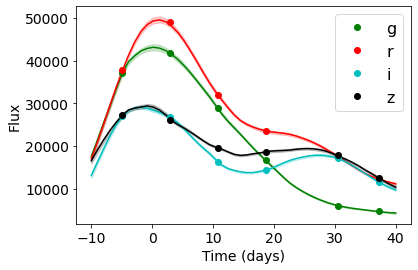

In [ ]:
f = plt.figure()
colors  = ['g', 'r', 'c', 'k']
offset = np.array([0, 1000,2000,3000]) * 30
offset = np.zeros(4)
for i, band_flux in enumerate(median_posterior_fit):
    plt.plot(np.linspace(-10, 40), band_flux + offset[i], color = colors[i])
    plt.fill_between(np.linspace(-10, 40), upper_posterior_fit[i]+ offset[i], lower_posterior_fit[i]+ offset[i], color = colors[i], alpha = 0.2)
for i, band_flux in enumerate(observed_fluxes):
  plt.plot(times_dict[bands[i]], band_flux + offset[i], 'o',color = colors[i], label = bands[i])
plt.legend(fontsize = 16)
# plt.title("Posterior samples from VI")
plt.xlabel("Time (days)", fontsize = 14)
plt.ylabel("Flux", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
f.savefig("LightCurve_ASASSN16cs_T21_072222.png", bbox_inches = 'tight')

##Compare to MCMC

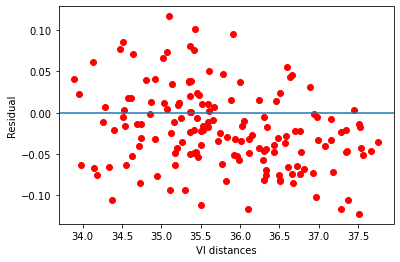

In [ ]:
mu_residuals = []
av_residuals = []
theta_residuals = []

mcmc_mus = []
mcmc_av = []
mcmc_theta = []
for sn in list(laplace_vi_loc_dict.keys()):
  #   vi_mus.append(vi_loc_dict[sn][-2])
  # vi_scale_tril = vi_scale_tril_dict[sn]
  # # Calculate covariance matrix from scale_tril (sigma = LL^T)
  # vi_vars.append(np.matmul(vi_scale_tril, vi_scale_tril.T)[-2][-2])
  # vi_z_cmbs.append(z_cmb_dict[sn])

  estimated_dist = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['mu'])
  estimated_av = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['AV'])
  estimated_theta = np.mean(np.load(sn + "_chains_210610_135216.npy", allow_pickle = True).item()['theta'])

  mcmc_mus.append(estimated_dist)
  mcmc_av.append(estimated_av)
  mcmc_theta.append(estimated_theta)

  # print(estimated_dist)
  # print(vi_loc_dict[sn][-2])
  # plt.plot(laplace_vi_loc_dict[sn][-2], estimated_dist, 'bo')
  plt.plot(laplace_vi_loc_dict[sn][-2], laplace_vi_loc_dict[sn][-2] - estimated_dist, 'ro')
  mu_residuals.append(laplace_vi_loc_dict[sn][-2] - estimated_dist)
  av_residuals.append(np.exp(laplace_vi_loc_dict[sn][-1])- estimated_av)
  # print(laplace_vi_loc_dict[sn][-1])
  theta_residuals.append(laplace_vi_loc_dict[sn][-3] - estimated_theta)



# plt.plot(np.linspace(33,38), np.linspace(33, 38), color = 'tab:orange')
plt.xlabel("VI distances")
# plt.ylabel("MCMC distances")
plt.ylabel("Residual")
plt.axhline(0)

plt.show()

In [ ]:
np.mean(mu_residuals) / (np.std(mu_residuals) / np.sqrt(len(mu_residuals)))

-5.187992062308975

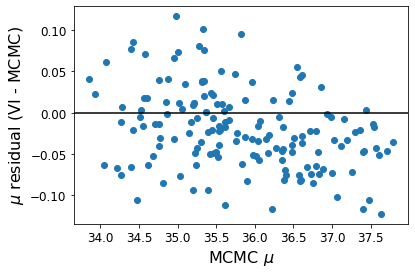

In [ ]:
f = plt.figure()
plt.plot(mcmc_mus, mu_residuals, 'o')
plt.axhline(0, color = 'k')
plt.xlabel("MCMC $\\mu$", fontsize = 16)
plt.ylabel("$\\mu$ residual (VI - MCMC)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
f.savefig("Foundation_mu_residuals.pdf", bbox_inches = 'tight')

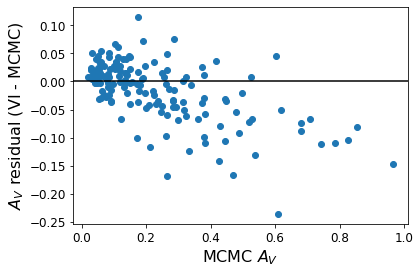

In [ ]:
f = plt.figure()
plt.plot(mcmc_av, av_residuals, 'o')
plt.axhline(0, color = 'k')
plt.xlabel("MCMC $A_V$", fontsize = 16)
plt.ylabel("$A_V$ residual (VI - MCMC)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
f.savefig("Foundation_AV_residuals.pdf", bbox_inches = 'tight')

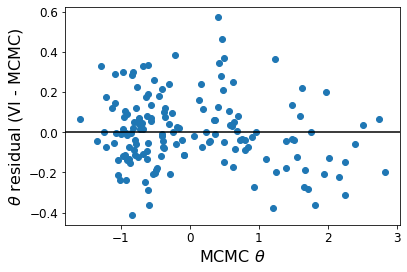

In [ ]:
# plt.plot(mcmc_theta, theta_residuals, 'o')
# plt.axhline(0, color = 'k')
# plt.xlabel("MCMC theta")
# plt.ylabel("Residual")

f = plt.figure()
plt.plot(mcmc_theta, theta_residuals, 'o')
plt.axhline(0, color = 'k')
plt.xlabel("MCMC $\\theta$", fontsize = 16)
plt.ylabel("$\\theta$ residual (VI - MCMC)", fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
f.savefig("Foundation_theta_residuals.pdf", bbox_inches = 'tight')

In [ ]:
list(laplace_vi_loc_dict.keys())[np.argmax(av_residuals)]

'ASASSN-15jt'

/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwargs)
/usr/local/lib/python3.7/dist-packages/corner/core.py:635: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, "o", zorder=-1, rasterized=True, **data_kwa

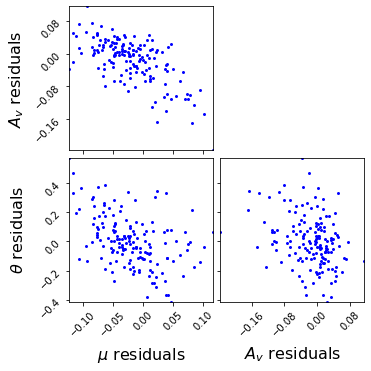

In [ ]:
fig = corner.corner(np.vstack((np.array(mu_residuals), av_residuals, theta_residuals)).T, 
              plot_contours = False, plot_datapoints =  True, plot_density = False, 
              data_kwargs = {'color':'b', 'alpha':1, 'marker':'o', 'markersize':3}, 
              labels = ['${\\mu}$ residuals', '${A_v}$ residuals', '${\\theta}$ residuals'],
              label_kwargs = {'fontsize':16})
# plt.text(-0.7,125,"All residuals are MCMC - VI", fontsize = 16)
# figure.suptitle("Parameter residuals for Foundation dataset", fontsize = 20)
axes = np.array(fig.axes).reshape((3, 3))
for a in axes[np.triu_indices(3)]:
  a.remove()

fig.savefig("Foundations_residuals_triangle.pdf", bbox_inches = 'tight')